In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [12]:
files = zf.ZipFile("dataset.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [13]:
os.remove("./dataset/.DS_Store")
os.listdir(os.path.join(os.getcwd(),"dataset"))

['plastic',
 'cardboard',
 'trash',
 'glass',
 'battery',
 'paper',
 'tetrapak',
 'metal']

## 2. Organize images into different folders


In [14]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.6*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, I'm going to create a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

Again, this is just housekeeping to organize my files.

In [15]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['plastic', 'cardboard', 'metal', 'trash', 'glass', 'battery', 'paper', 'tetrapak']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

I set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [16]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/home/mariobru/git_ironhack/reciclAPI/data')

In [17]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

You can use get_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [18]:
data

ImageDataBunch;

Train: LabelList (3139 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /home/mariobru/git_ironhack/reciclAPI/data;

Valid: LabelList (1047 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /home/mariobru/git_ironhack/reciclAPI/data;

Test: LabelList (1052 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/mariobru/git_ironhack/reciclAPI/data

In [19]:
print(data.classes)

['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'tetrapak', 'trash']


Here's an example of what the data looks like:

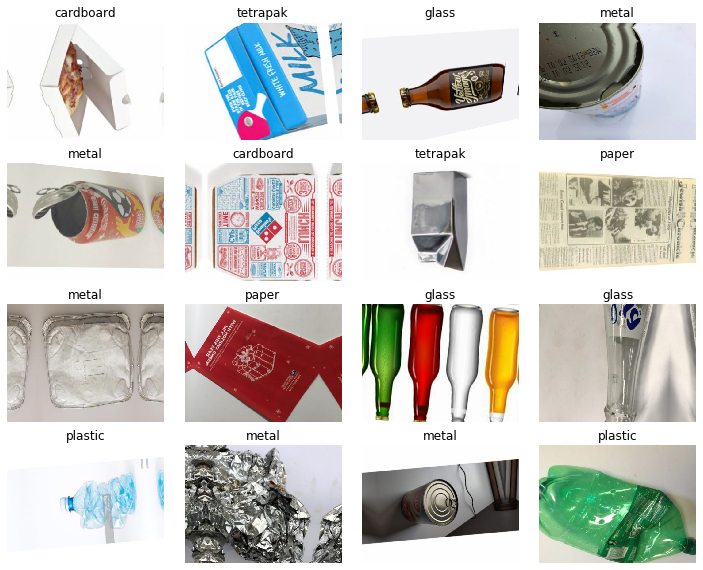

In [20]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [21]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate, callback_fns=ShowGraph)

### What is resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

Since they're capable of describing more complexity, deep neural networks should theoretically perform better than shallow networks on training data. In reality, though, deep neural networks tend to perform empirically worse than shallow ones. 

Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals). 

When adjustments are needed, shortcut connections apply the identity function to pass information to subsequent layers. This shortens the neural network when possible and allows resnets to have deep architectures and behave more like shallow neural networks. The 34 in resnet34 just refers to the number of layers.

Anand Saha gives a great more in-depth explanation [here](http://teleported.in/posts/decoding-resnet-architecture/).

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Finding a learning rate

I'm going to find a learning rate for gradient descent to make sure that my neural network converges reasonably quickly without missing the optimal error. For a refresher on the learning rate, check out Jeremy Jordan's [post](https://www.jeremyjordan.me/nn-learning-rate/) on choosing a learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 5.75E-03


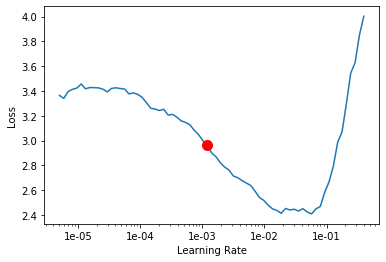

In [24]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

### Training

epoch,train_loss,valid_loss,accuracy,time
0,1.201819,0.516250,0.825215,00:48
1,1.058329,0.447794,0.847182,00:49
2,0.795990,0.387718,0.859599,00:48
3,0.703517,0.381737,0.870105,00:49
4,0.765002,0.372641,0.868195,00:49
5,0.736592,0.412316,0.869150,00:50
6,0.677425,0.445082,0.860554,00:51
7,0.665198,0.341419,0.883477,00:49
8,0.596565,0.361088,0.879656,00:50
9,0.506332,0.299736,0.898758,00:49


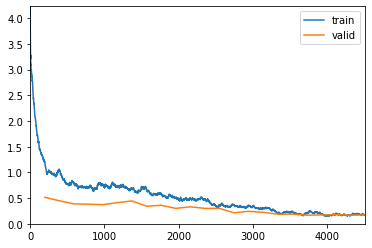

In [25]:
learn.metrics=[accuracy]
learn.fit_one_cycle(23,max_lr=slice(1.20E-03,5.75E-03))

### Saving and loading Model

In [708]:
learn.save("resnet50_best")

In [141]:
learn = learn.load("best_model")

### VIsualizing most incorrect images

In [142]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

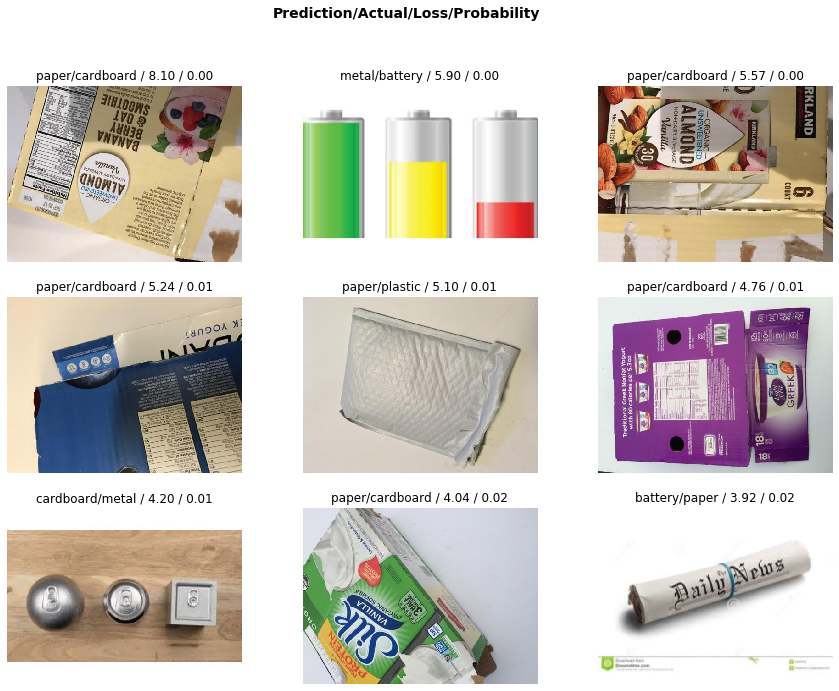

In [143]:
interp.plot_top_losses(9, figsize=(15,11))

The images here that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

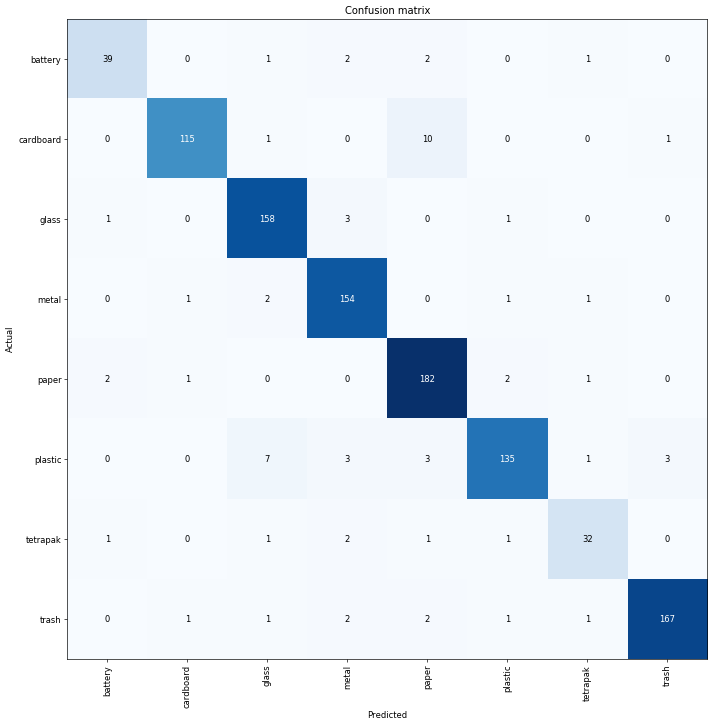

In [144]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [145]:
interp.most_confused(min_val=2)

[('cardboard', 'paper', 10),
 ('plastic', 'glass', 7),
 ('glass', 'metal', 3),
 ('plastic', 'metal', 3),
 ('plastic', 'paper', 3),
 ('plastic', 'trash', 3),
 ('battery', 'metal', 2),
 ('battery', 'paper', 2),
 ('metal', 'glass', 2),
 ('paper', 'battery', 2),
 ('paper', 'plastic', 2),
 ('tetrapak', 'metal', 2),
 ('trash', 'metal', 2),
 ('trash', 'paper', 2)]

## Loading a single image and testing it with our model

In [146]:
img = open_image('new_test/test2.jpg')

In [147]:
img.data.shape
new_height = 512 * img.data.shape[1] / img.data.shape[2]

In [148]:
img.resize(torch.Size([img.shape[0],int(new_height),512]))
img.data.shape

torch.Size([3, 387, 512])

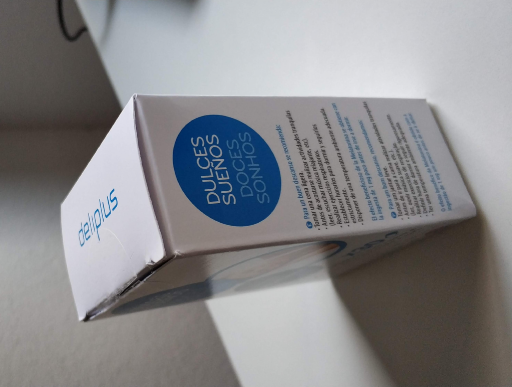

In [149]:
img

In [150]:
pred_class,pred_idx,outputthirds = learn.predict(img)
pred_class

Category paper

## 4. Make new predictions on test data

To see how this mode really performs, we need to make predictions on test data. First, I'll make predictions on the test data using the learner.get_preds() method. 

**Note:** learner.predict() only predicts on a single image, while learner.get_preds() predicts on a set of images. I highly recommend reading the [documentation](https://docs.fast.ai/basic_train.html#Learner.get_preds) to learn more about predict() and get_preds().

In [151]:
preds = learn.get_preds(ds_type=DatasetType.Test)

The ds_type argument in get_preds(ds_type) takes a [DataSet](https://docs.fast.ai/basic_data.html#DatasetType) argument. Example values are DataSet.Train, DataSet.Valid, and DataSet.Test. I mention this because I made the mistake of passing in actual data (learn.data.test_ds) which gave me the wrong output and took embarrassingly long to debug. 

Don't make this mistake! Don't pass in data -- pass in the dataset type!

In [152]:
print(preds[0].shape)
preds[0]

torch.Size([1052, 8])


tensor([[1.2509e-07, 7.4666e-04, 1.1494e-05,  ..., 1.8245e-06, 9.3420e-06,
         9.8933e-06],
        [3.9729e-05, 9.7719e-01, 1.6947e-06,  ..., 1.7775e-04, 2.8260e-03,
         1.4704e-05],
        [6.0646e-06, 1.9012e-07, 1.2194e-03,  ..., 9.9054e-01, 1.2508e-05,
         7.4545e-03],
        ...,
        [6.0650e-06, 9.9522e-06, 9.9341e-01,  ..., 1.9326e-03, 2.3366e-06,
         6.3792e-05],
        [9.9719e-01, 8.5332e-05, 2.3505e-04,  ..., 1.1011e-06, 3.6255e-04,
         8.8097e-05],
        [1.8215e-03, 8.3483e-07, 1.6508e-04,  ..., 4.4767e-05, 2.1650e-04,
         1.5359e-05]])

These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [153]:
data.classes

['battery',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'plastic',
 'tetrapak',
 'trash']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [154]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [155]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [156]:
yhat[27]

'paper'

These are the predicted labels of all the images! Let's check if the first image is actually glass.

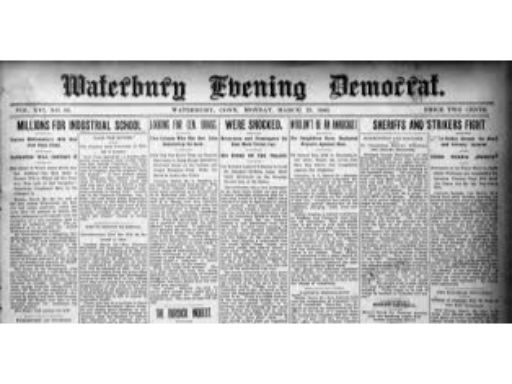

In [157]:
learn.data.test_ds[27][0]

It is!

Next, I'll get the actual labels from the test dataset.

In [158]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [159]:
## predicted values
print(yhat[55:65])
## actual values
print(y[55:65])

['metal', 'paper', 'trash', 'plastic', 'trash', 'plastic', 'plastic', 'trash', 'trash', 'trash']
['metal', 'paper', 'trash', 'metal', 'trash', 'plastic', 'plastic', 'trash', 'trash', 'trash']


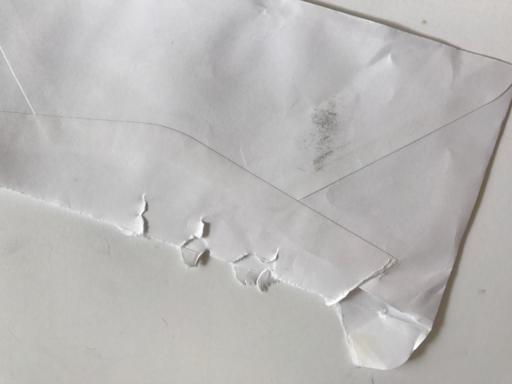

In [160]:
learn.data.test_ds[0][0]

It looks the first five predictions match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [161]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 40   0   0   4   0   0   2   0]
 [  0 121   0   0   4   0   1   1]
 [  1   0 156   5   1   0   0   0]
 [  1   1  10 145   0   1   0   2]
 [  0   1   0   1 187   0   0   0]
 [  0   0   7   4   4 133   3   1]
 [  1   2   0   0   0   0  36   0]
 [  0   1   2   1   1   2   2 167]]


Let's try and make this matrix a little prettier.

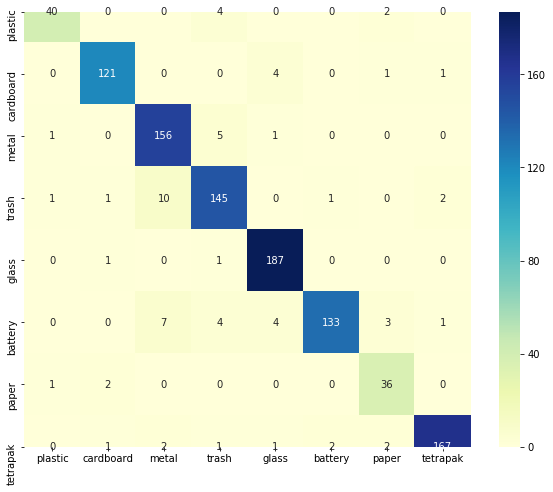

In [162]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, I'm sure further investigation could help reduce these mistakes.

In [163]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [164]:
accuracy = correct/sum(sum(cm))
accuracy

0.9363117870722434